In [1]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [2]:
data, dataName = loadData.loadData("oy_all.csv")

intensityVariable = "deltaDurS"
sensoryVar = "audNoise"
standardVar = "standardDur"
conflictVar = "conflictDur"
#s
visualStandardVar = "unbiasedVisualStandardDur"
visualTestVar = "unbiasedVisualTestDur"
audioStandardVar = "standardDur"
audioTestVar = "testDurS"



 Total trials before cleaning
: 2171
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 2171


In [3]:
# Instantiate the Monte Carlo class
mc_fitter = monteCarloClass.OmerMonteCarlo(data)
mc_fitter.dataName=dataName


In [4]:
print("Data shape:", data.shape)
print("\nConflict range:", data["conflictDur"].min(), "to", data["conflictDur"].max())
print("Standard duration:", data["standardDur"].unique())
print("Audio noise levels:", sorted(data["audNoise"].unique()))
print("Visual test duration range:", data["recordedDurVisualTest"].min(), "to", data["recordedDurVisualTest"].max())
print("t_min, t_max:", mc_fitter.t_min, mc_fitter.t_max)

Data shape: (2171, 57)

Conflict range: -0.25 to 0.25
Standard duration: [0.5]
Audio noise levels: [np.float64(0.1), np.float64(1.2)]
Visual test duration range: 0.0909 to 1.1507
t_min, t_max: 0.02507 0.95255


In [5]:
mc_fitter.nSimul = 1000
mc_fitter.optimizationMethod= "bads"  # Use BADS for optimization
mc_fitter.nStart = 1 # Number of random starts for optimization
mc_fitter.modelName = "lognorm"  # Set measurement distribution to Gaussian
mc_fitter.freeP_c= True  # Allow parameter c to be free
mc_fitter.sharedLambda=False # Allow lambda to vary across conditions
mc_fitter.sharedSigma_v=True # Allow sigma to vary across conditions

In [6]:
timeStart = time.time()
print(f"\nFitting Causal Inference Model for {dataName} with {len(mc_fitter.groupedData)} unique conditions")
fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(mc_fitter.groupedData)
print(f"\nFitted parameters for {dataName}: {fittedParams}")
print(f"Time taken to fit: {time.time() - timeStart:.2f} seconds")
mc_fitter.modelFit= fittedParams
mc_fitter.logLikelihood= -mc_fitter.nLLMonteCarloCausal(fittedParams, mc_fitter.groupedData)


Fitting Causal Inference Model for oy_all with 674 unique conditions
Fitting with free p_c parameters for each SNR condition.

Starting 1 optimization attempts using 'bads'...
Model is lognorm


Optimization Attempts: 100%|██████████| 1/1 [07:35<00:00, 455.94s/it]



✅ Best result from 1 attem           spts:
  → Final parameters: [0.06848111 0.29231339 1.19999759 0.6524101  0.41520305 0.10333517
 0.19057594 0.80079814]
  → Final log-likelihood: 1158.744653

Fitted parameters for oy_all: [0.06848111 0.29231339 1.19999759 0.6524101  0.41520305 0.10333517
 0.19057594 0.80079814]
Time taken to fit: 455.97 seconds


# Load Data

In [ ]:
# read back the saved file to verify

import os
import json
def loadFitResults(dataName, modelName="lognorm",lapseShared=True):
    participantID = dataName.split('_')[0]
    if lapseShared:
        modelName += "_lapseFix"
    else:
        modelName += "_lapseFree"
    
    if mc_fitter.freeP_c:
        modelName += "_contextualPrior"


    filepath = os.path.join("model_fits", participantID, f"{participantID}_{modelName}_fit.json")
    try:
        with open(filepath, 'r') as f:
            results = json.load(f)
        return results
    except FileNotFoundError:
        print(f"No saved fit results found for {dataName} with model {modelName}.")
        return None

res=loadFitResults(dataName, modelName="lognorm")

No saved fit results found for oy_all with model lognorm_lapseFix_contextualPrior.


In [ ]:
import os
import numpy as np
import json
def saveFitResultsSingle(fitter,fittedParams, dataName,modelType="lognorm",lapseShared=True):
    participantID = dataName.split('_')[0]
    save_dir = os.path.join("model_fits", participantID)
    if mc_fitter.freeP_c:
        modelType += "_contextualPrior"
    else:
        modelType += "_sharedPrior"

    
    
    if lapseShared:
        filename = f"{participantID}_{modelType}_LapseFix_fit.json"
    else:
        filename = f"{participantID}_{modelType}_LapseFree_fit.json"

    filepath = os.path.join(save_dir, filename)

    # make directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # calculate AIC and BIC
    k=len(fittedParams) # number of parameters
    n=len(fitter.groupedData) # number of data points
    fitter.logLikelihood= -fitter.nLLMonteCarloCausal(fittedParams, fitter.groupedData)
    aic= 2*k - 2*fitter.logLikelihood
    bic= np.log(n)*k - 2*fitter.logLikelihood

    

    # store results in a dictionary
    results_dict = {
        "participantID": participantID,
        "modelType": modelType,
        "fittedParams": fittedParams.tolist() if isinstance(fittedParams, np.ndarray) else fittedParams,
        "AIC": float(aic),
        "BIC": float(bic),
        "logLikelihood": fitter.logLikelihood,
        "n_conditions": n

    }


    # Save JSON
    with open(filepath, 'w') as f:
        json.dump(results_dict, f, indent=4)
        
    print(f"✅ Saved fit for {participantID} ({modelType}) to: {filepath}")

#saveFitResultsSingle(fittedParams, dataName, modelType="lognormal")

dataName= mc_fitter.dataName
saveFitResultsSingle(mc_fitter,mc_fitter.modelFit, dataName, modelType="lognorm",lapseShared=False)

✅ Saved fit for oy (lognorm_contextualPrior) to: model_fits/oy/oy_lognorm_contextualPrior_LapseFree_fit.json


## Simulate data using fitted parameters

In [ ]:
mc_fitter.dataName

'oy_all'

In [ ]:
mc_fitter.simulatedData = mc_fitter.simulateMonteCarloData(fittedParams, mc_fitter.data, nSamples=100)
mc_fitter.simDataFit=mc_fitter.fitMultipleStartingPoints(mc_fitter.simulatedData,1)

"psychometric fit"
mc_fitter.dataFit= mc_fitter.fitMultipleStartingPoints(data,1)

Plotting psychometric curves for Monte Carlo model and data...
Noise: 0.1, Conflict: -0.25, Lambda: 0.084, Sigma_a: 0.327, Sigma_v: 0.777, p_c: 0.338
Noise: 0.1, Conflict: -0.17, Lambda: 0.057, Sigma_a: 0.327, Sigma_v: 0.777, p_c: 0.338
Noise: 0.1, Conflict: -0.08, Lambda: 0.039, Sigma_a: 0.327, Sigma_v: 0.777, p_c: 0.338
Noise: 0.1, Conflict: 0.0, Lambda: 0.057, Sigma_a: 0.327, Sigma_v: 0.777, p_c: 0.338
Noise: 0.1, Conflict: 0.08, Lambda: 0.084, Sigma_a: 0.327, Sigma_v: 0.777, p_c: 0.338
Noise: 0.1, Conflict: 0.17, Lambda: 0.039, Sigma_a: 0.327, Sigma_v: 0.777, p_c: 0.338
Noise: 0.1, Conflict: 0.25, Lambda: 0.057, Sigma_a: 0.327, Sigma_v: 0.777, p_c: 0.338
Noise: 1.2, Conflict: -0.25, Lambda: 0.084, Sigma_a: 0.470, Sigma_v: 0.777, p_c: 0.669
Noise: 1.2, Conflict: -0.17, Lambda: 0.057, Sigma_a: 0.470, Sigma_v: 0.777, p_c: 0.669
Noise: 1.2, Conflict: -0.08, Lambda: 0.039, Sigma_a: 0.470, Sigma_v: 0.777, p_c: 0.669
Noise: 1.2, Conflict: 0.0, Lambda: 0.057, Sigma_a: 0.470, Sigma_v: 0.777

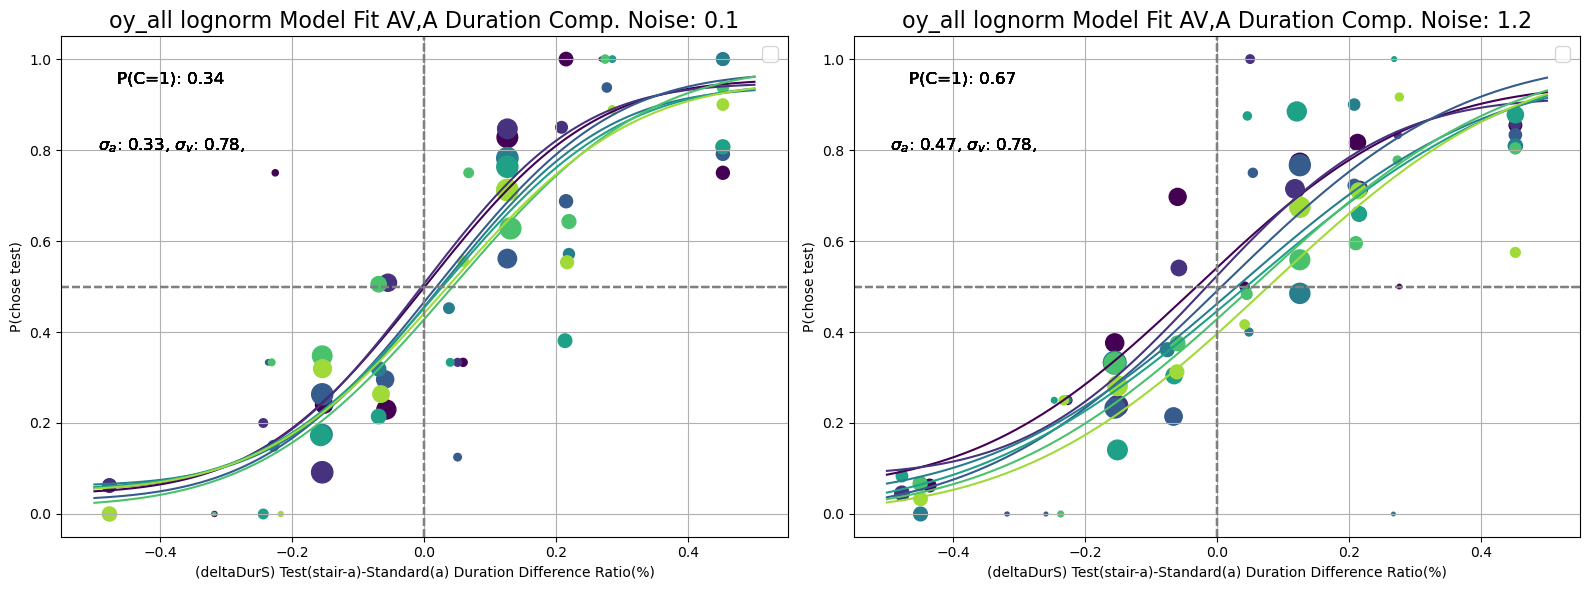

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
# mc_fitter.dataName = dataName
# mc_fitter.data= data
# mc_fitter.visualStandardVar = visualStandardVar
# mc_fitter.visualTestVar = visualTestVar
# mc_fitter.audioTestVar = audioTestVar

mc_fitter.plotPsychometrics_MC_Data()

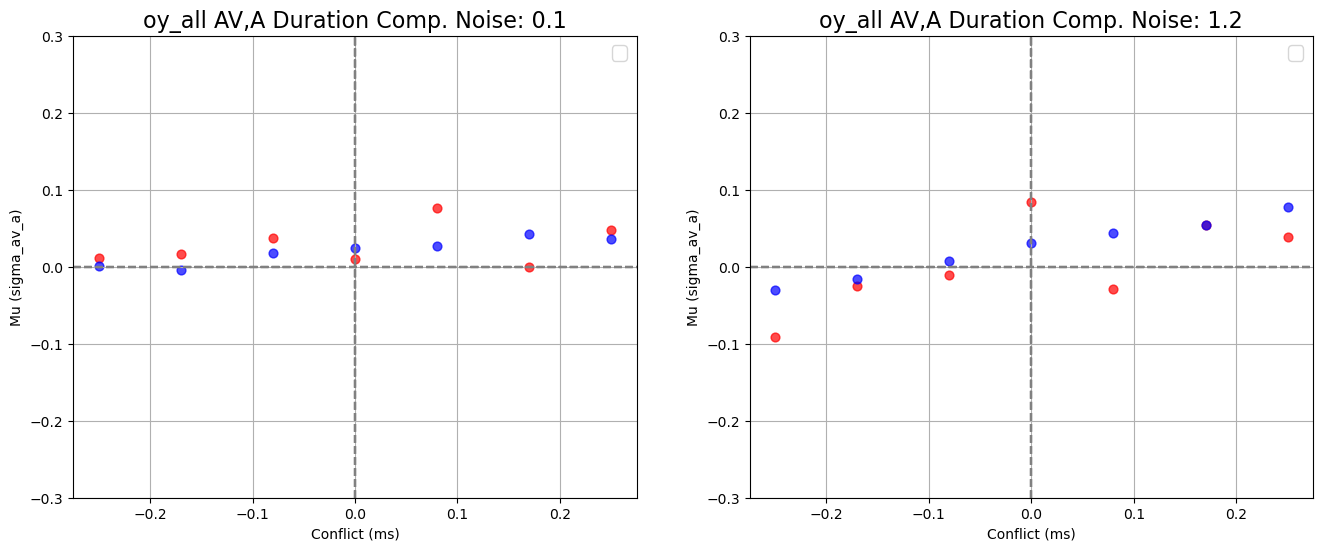

In [ ]:

mc_fitter.plot_mu_vs_conflict_MC_vs_Data()

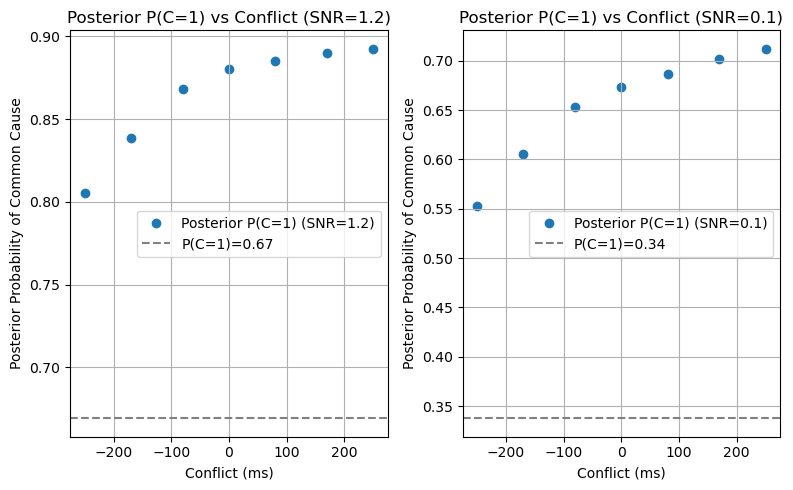

In [ ]:
mc_fitter.plot_posterior_vs_conflict(mc_fitter.data, fittedParams)

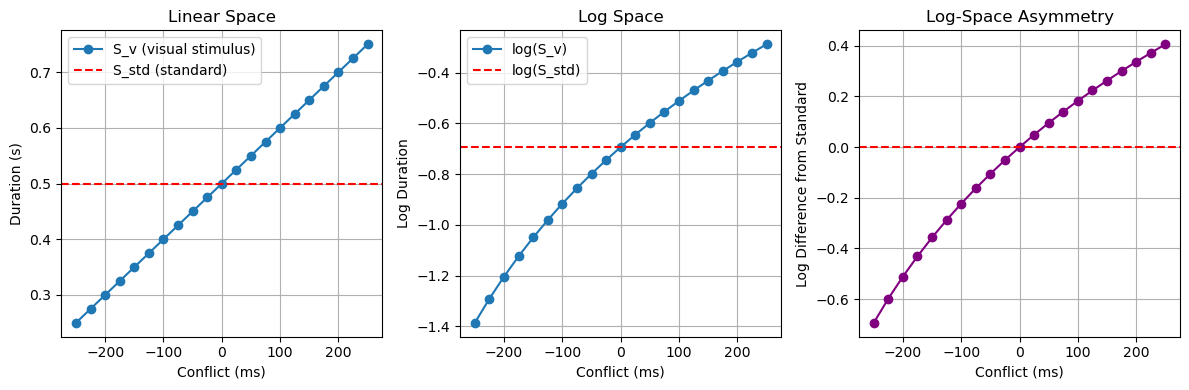

Log differences analysis:
For -250ms conflict: log difference = -0.693
For +250ms conflict: log difference = 0.405
Asymmetry ratio: 1.71


In [ ]:
# Diagnostic plot to understand the log-space asymmetry
import matplotlib.pyplot as plt
import numpy as np

# Define the conflict range and standard duration
conflicts = np.linspace(-0.25, 0.25, 21)
S_std = 0.5
S_v_values = S_std + conflicts

# Calculate log differences
log_S_std = np.log(S_std)
log_S_v_values = np.log(S_v_values)
log_differences = log_S_v_values - log_S_std

plt.figure(figsize=(12, 4))

# Plot 1: Linear space
plt.subplot(1, 3, 1)
plt.plot(conflicts * 1000, S_v_values, 'o-', label='S_v (visual stimulus)')
plt.axhline(y=S_std, color='red', linestyle='--', label='S_std (standard)')
plt.xlabel('Conflict (ms)')
plt.ylabel('Duration (s)')
plt.title('Linear Space')
plt.legend()
plt.grid(True)

# Plot 2: Log space
plt.subplot(1, 3, 2)
plt.plot(conflicts * 1000, log_S_v_values, 'o-', label='log(S_v)')
plt.axhline(y=log_S_std, color='red', linestyle='--', label='log(S_std)')
plt.xlabel('Conflict (ms)')
plt.ylabel('Log Duration')
plt.title('Log Space')
plt.legend()
plt.grid(True)

# Plot 3: Log differences (this shows the asymmetry!)
plt.subplot(1, 3, 3)
plt.plot(conflicts * 1000, log_differences, 'o-', color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Conflict (ms)')
plt.ylabel('Log Difference from Standard')
plt.title('Log-Space Asymmetry')
plt.grid(True)

plt.tight_layout()
plt.show()

print("Log differences analysis:")
print(f"For -250ms conflict: log difference = {log_differences[0]:.3f}")
print(f"For +250ms conflict: log difference = {log_differences[-1]:.3f}")
print(f"Asymmetry ratio: {abs(log_differences[0]) / abs(log_differences[-1]):.2f}")

# N simulations values to try

In [ ]:
nSimul_values = [100,500,1000,2000]
results = []
mc_fitter.modelName = "lognorm"  # Set measurement distribution to lognormal

mc_fitter.nStart = 1  # Number of random starts for optimization
mc_fitter.optimizationMethod = "bads"  # Use BADS for optimization
for nSimul in nSimul_values:
    mc_fitter.nSimul = nSimul
    fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(mc_fitter.groupedData)
    log_likelihood = -mc_fitter.nLLMonteCarloCausal(fittedParams, mc_fitter.groupedData)
    results.append((nSimul, fittedParams, log_likelihood))

# Compare results
for nSimul, params, ll in results:
    print(f"nSimul: {nSimul}, Log-Likelihood: {ll:.4f}, Params: {params}")

Fitting with free p_c parameters for each SNR condition.

Starting 1 optimization attempts using 'bads'...
Model is lognorm


Optimization Attempts: 100%|██████████| 1/1 [03:18<00:00, 198.50s/it]



✅ Best result from 1 attem           spts:
  → Final parameters: [0.09489388 0.3227646  0.67898685 0.47975051 0.40232988 0.08292099
 0.17921154 0.74184076]
  → Final log-likelihood: 1163.902948
Fitting with free p_c parameters for each SNR condition.

Starting 1 optimization attempts using 'bads'...
Model is lognorm


Optimization Attempts:   0%|          | 0/1 [03:24<?, ?it/s]


KeyboardInterrupt: 

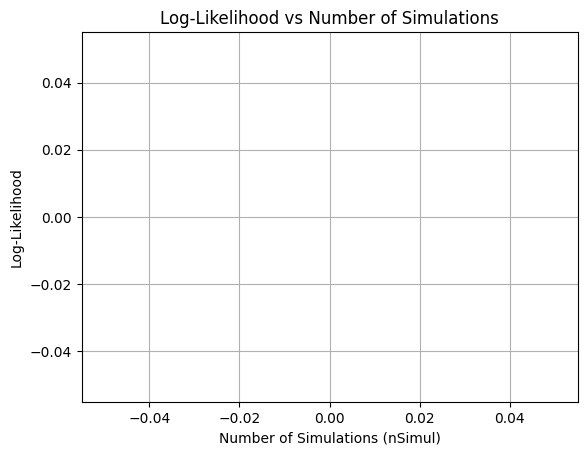

In [ ]:
#plot the log likelihood vs nSimul
plt.figure()
plt.plot([r[0] for r in results], [r[2] for r in results], marker='o')
plt.xlabel('Number of Simulations (nSimul)')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Number of Simulations')
plt.grid()
plt.show()

# Number of Starting Points for Optimization

In [ ]:
nStartValues = [5,10,20]
results = []
mc_fitter.modelName = "lognorm"  # Set measurement distribution to lognormal

mc_fitter.nSimul = 1000
mc_fitter.optimizationMethod = "bads"  # Use BADS for optimization
for nStart in nStartValues:
    mc_fitter.nStart = nStart
    fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(mc_fitter.groupedData)
    log_likelihood = -mc_fitter.nLLMonteCarloCausal(fittedParams, mc_fitter.groupedData)
    results.append((nSimul, fittedParams, log_likelihood))
    

# # Compare results
# for nSimul, params, ll in results:
#     print(f"nSimul: {nSimul}, Log-Likelihood: {ll:.4f}, Params: {params}")
#plot the log likelihood vs nStart
plt.figure()
plt.plot([r[0] for r in results], [r[2] for r in results], marker='o')
plt.xlabel('Number of Starting Points (nStart)')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Number of Starting Points')
plt.grid()
plt.show()


Starting 5 optimization attempts using 'bads'...


Optimization Attempts:  80%|████████  | 4/5 [16:43<04:10, 250.94s/it]


KeyboardInterrupt: 